<a href="https://colab.research.google.com/github/ferdouszislam/Bangla-Handwritting-Aesthetics-Prediction-ML/blob/main/codes/experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import math
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from skimage import io

In [2]:
# mount gdrive with this code
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# extract the zip file containing our dataset
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/BanglaLekha-Isolated_aesthetics_dataset/prepared-datasets.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
# custom dataset class
class BanglaAestheticsDataset(Dataset):
  def __init__(self, labels_csv_file, img_dir, transform=None):
    self.labels_df = pd.read_csv(labels_csv_file)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.labels_df)

  def __getitem__(self, index):
    img_path = os.path.join(self.img_dir, self.labels_df.iloc[index, 0])
    image = io.imread(img_path)
    if self.transform:
      image = self.transform(image)
    y_label = torch.tensor(int(self.labels_df.iloc[index, 3]))
    
    return (image, y_label)

In [6]:
# load data

# resize to same shape and convert to tensor
custom_transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((50, 50)), transforms.ToTensor()])

train_dataset = BanglaAestheticsDataset(labels_csv_file='/tmp/prepared-datasets/aesthetics_train.csv', 
                                        img_dir='/tmp/prepared-datasets/train_images', transform=custom_transform)

val_dataset = BanglaAestheticsDataset(labels_csv_file='/tmp/prepared-datasets/aesthetics_val.csv', 
                                        img_dir='/tmp/prepared-datasets/validation_images', transform=custom_transform)

test_dataset = BanglaAestheticsDataset(labels_csv_file='/tmp/prepared-datasets/aesthetics_test.csv', 
                                        img_dir='/tmp/prepared-datasets/test_images', transform=custom_transform)

In [7]:
# data loaders

batch_size = 64 # no of samples in a single batch

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

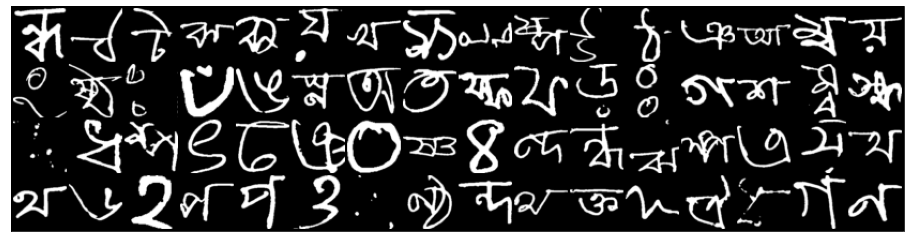

In [8]:
# visualize data
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(val_loader)

# ANN experimentation starts from here

In [9]:
# ann hyperparameters
input_size = 50*50
fc1_size = 512
fc2_size = 128
fc3_size = 32
num_epochs = 100
learning_rate = 0.001

In [10]:
# custom ANN class with 3 hidden layers, relu activation and dropout of 0.5 on each hidden layer
class ANN(nn.Module):
  def __init__(self, input_size, fc1_size, fc2_size, fc3_size):
    super(ANN, self).__init__()
    self.fc1 = nn.Linear(input_size, fc1_size)
    self.dropout_fc1 = nn.Dropout(0.5)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(fc1_size, fc2_size)
    self.dropout_fc2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(fc2_size, fc3_size)
    self.dropout_fc3 = nn.Dropout(0.5)
    self.output_layer = nn.Linear(fc3_size, 1)

  def forward(self, input):
    # input layer to hidden layer 1
    output = self.dropout_fc1(self.fc1(input))
    output = self.relu(output)
    # hidden layer 1 to hidden layer 2
    output = self.dropout_fc2(self.fc2(output))
    output = self.relu(output)
    # hidden layer 2 to hidden layer 3
    output = self.dropout_fc3(self.fc3(output))
    output = self.relu(output)
    # hidden layer 3 to output
    output = self.output_layer(output)
    pred = torch.sigmoid(output) # probability prediction
    return pred

In [11]:
# custom cnn class 
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
        
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.Dropout(0.25),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_layer2 =  nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.Dropout(0.25),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # 1x50x50 --conv1--> 16x50x50 --maxpool--> 16x25x25
    # 16x25x25 --conv2--> 8x25x25 --maxpool--> 8x12x12

    self.fc1 = nn.Linear(32*12*12, 256) 
    self.fc2 = nn.Linear(256, 64)
    self.relu = nn.ReLU()
    self.fc_dropout = nn.Dropout(0.5)
    self.output_layer = nn.Linear(64, 1)
      
  def forward(self, input):
    #print('inside forward', input.shape)

    # input to conv_layer1
    output = self.conv_layer1(input)
    #print('after conv1', output.shape)

    # conv_layer1 to conv_layer2
    output = self.conv_layer2(output)
    #print('after conv2', output.shape)

    # conv_layer2 to fc1
    output = output.reshape(-1, 32*12*12) # flatten
    output = self.fc1(output)
    output = self.relu(self.fc_dropout(output))

    # fc1 to fc2
    output = self.fc2(output)
    output = self.relu(self.fc_dropout(output))

    # fc2 to prediction
    output = self.output_layer(output)
    pred = torch.sigmoid(output)

    return pred


In [12]:
PATH_TO_ANN_MODEL = 'ann_model.pth'
PATH_TO_CNN_MODEL = 'cnn_model.pth'

# training loop
def train(model, optimizer, criterion, train_loader, num_epochs, SAVE_PATH, flatten_input=True):
  min_valid_loss = np.inf
  total_train_step = len(train_loader)
  
  # train loop
  for epoch in range(num_epochs):
    train_loss = 0.0
    model.train() # set the model in train mode
    for step, (images, labels) in enumerate(train_loader):
      if flatten_input:
        images = images.reshape(-1, 50*50) # flatten image
        #print("image flattened -", images.shape)
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      labels = labels.unsqueeze(1)
      labels = labels.float()

      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # accumulate training loss
      train_loss+=loss.item()

    valid_loss = 0.0
    model.eval() # set the model to evaluation mode
    with torch.no_grad():
      for step, (images, labels) in enumerate(val_loader):
        if flatten_input:
          images = images.reshape(-1, 50*50) # flatten image
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        labels = labels.unsqueeze(1)
        labels = labels.float()

        loss = criterion(outputs, labels)

        # accumulate validation loss
        valid_loss+=loss.item()

    train_loss /= len(train_loader)
    valid_loss /= len(val_loader)
    print(f'epoch {epoch+1} --- training loss: {train_loss:.4f} --- validation loss: {valid_loss:.4f}')

    if min_valid_loss > valid_loss:
        print(f'validation loss decreased({min_valid_loss:.4f}--->{valid_loss:.4f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        #torch.save(model, 'saved_model.pth')
        model.to(device)
        torch.save(model.state_dict(), SAVE_PATH)

# evaluation 
def eval(model, test_loader, flatten_input=True):
  model.eval()
  with torch.no_grad():
    n_correct_samples = 0
    n_total_samples = 0
    for imgs, labels in test_loader:
      if flatten_input:
        imgs = imgs.reshape(-1, 50*50)
      imgs = imgs.to(device)
      labels = labels.to(device).reshape(-1, 1)

      outputs = model(imgs)

      #pred = outputs.round() # if outputs>=0.5 class = 1, else class = 0
      pred = torch.round(outputs)

      #print(pred.shape, labels.shape)
      
      n_total_samples+=labels.size(0)
      n_correct_samples+=pred.eq(labels).sum().item()

    print(f'Accuracy = {100*n_correct_samples/n_total_samples : 0.3f}')

In [ ]:
# init model with ANN
model = ANN(input_size=input_size, fc1_size=fc1_size, fc2_size=fc2_size, fc3_size=fc3_size)
model = model.to(device)

# init loss function, optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model, optimizer, criterion, train_loader, num_epochs, SAVE_PATH=PATH_TO_ANN_MODEL)

epoch 1 --- training loss: 0.6665 --- validation loss: 0.6358
validation loss decreased(inf--->0.6358) 	 Saving The Model


In [ ]:
model = ANN(input_size=input_size, fc1_size=fc1_size, fc2_size=fc2_size, fc3_size=fc3_size)
model.load_state_dict(torch.load(PATH_TO_ANN_MODEL))
model = model.to(device)
eval(model=model, test_loader=test_loader)

Accuracy =  67.403


In [13]:
# init model with CNN
model = CNN()
model = model.to(device)

# init loss function, optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model, optimizer, criterion, train_loader, num_epochs, SAVE_PATH=PATH_TO_CNN_MODEL, flatten_input=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 1 --- training loss: 0.6418 --- validation loss: 0.6313
validation loss decreased(inf--->0.6313) 	 Saving The Model
epoch 2 --- training loss: 0.6052 --- validation loss: 0.6054
validation loss decreased(0.6313--->0.6054) 	 Saving The Model
epoch 3 --- training loss: 0.5873 --- validation loss: 0.5861
validation loss decreased(0.6054--->0.5861) 	 Saving The Model
epoch 4 --- training loss: 0.5758 --- validation loss: 0.5729
validation loss decreased(0.5861--->0.5729) 	 Saving The Model
epoch 5 --- training loss: 0.5655 --- validation loss: 0.5687
validation loss decreased(0.5729--->0.5687) 	 Saving The Model
epoch 6 --- training loss: 0.5579 --- validation loss: 0.5909
epoch 7 --- training loss: 0.5503 --- validation loss: 0.5742
epoch 8 --- training loss: 0.5461 --- validation loss: 0.5755
epoch 9 --- training loss: 0.5386 --- validation loss: 0.5680
validation loss decreased(0.5687--->0.5680) 	 Saving The Model
epoch 10 --- training loss: 0.5361 --- validation loss: 0.5700
epoc

In [14]:
model = CNN()
model.load_state_dict(torch.load(PATH_TO_CNN_MODEL))
model = model.to(device)
eval(model=model, test_loader=test_loader, flatten_input=False)

Accuracy =  71.999
